In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split
from functools import partial

### Files

In [5]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/'
else:
    path = './'

In [6]:
Y_file = sci.loadmat(path + 'Y_clean.mat')
Y_clean = Y_file['Y_clean'].astype(float)

A_file = sci.loadmat(path + 'A_true.mat')
A_true = A_file['A_true']

E_file = sci.loadmat(path + 'E.mat')
E = E_file['E']

nCol, nRow = 95, 95
n, m = 96, 96
r_channels = 3
p = 156

### Images shapes

In [7]:
A_true.shape, E.shape, Y_clean.shape

((95, 95, 3), (156, 3), (95, 95, 156))

In [8]:
Y = np.zeros((n, m, p))
Y[:-1, :-1] = Y_clean
Y[-1, :], Y[:, -1] = 0, 0

A_gt = np.zeros((n, m, r_channels))
A_gt[:-1, :-1] = A_true
A_gt[-1, :], A_gt[:, -1] = 0, 0

Y.shape, A_gt.shape

((96, 96, 156), (96, 96, 3))

### Abundances

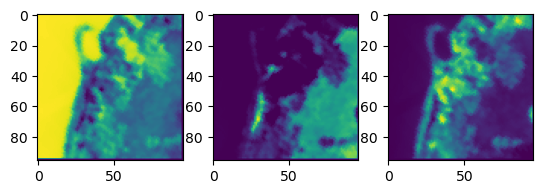

In [9]:
for i in range(3): 
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(A_gt[:,:,i])

### Endmembers

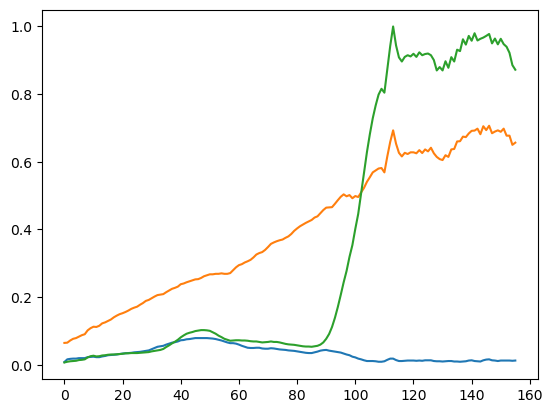

In [10]:
plt.plot(E)

### Y

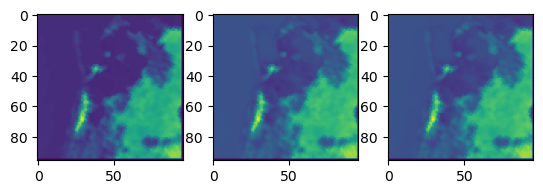

In [11]:
for i in range(3): 
      ax = plt.subplot(1, 3, i+1)
      ax.imshow(np.transpose(Y, (2,0,1))[i,:,:])

### Ground truth loss

In [12]:
A_gt_tensor = torch.tensor(np.transpose(A_gt, (2,0,1)), dtype=torch.float32)
E_tensor = torch.tensor(E, dtype=torch.float32)
Y_tensor = torch.tensor(np.transpose(Y, (2,0,1)).reshape((p, n*m)), dtype=torch.float32)
A_gt_tensor.shape, E_tensor.shape, Y_tensor.shape

(torch.Size([3, 96, 96]), torch.Size([156, 3]), torch.Size([156, 9216]))

In [13]:
criterion = nn.MSELoss()
loss = criterion(torch.mm(E_tensor, A_gt_tensor.view(r_channels, n*m)), Y_tensor)
loss

tensor(1.7039e-16)

### Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), 
                                            stride=(2, 2), padding_mode='reflect', padding=1, dilation=1), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), 
                                        padding=0, dilation=1),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True, negative_slope=0.1),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0],
                                            (3, 3), stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.Softmax(dim=1)
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output



def train(model, input, E_tensor, Y_tensor, epochs=2000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  E_tensor = E_tensor.to(device)
  Y_tensor = Y_tensor.to(device)


  losses = []
  outputs = torch.zeros([epochs, 1, r_channels, n, m])
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input)

    #loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    loss = criterion(torch.mm(E_tensor, output.view(r_channels, n*m)), Y_tensor)
    #loss = criterion(output, gt_fractional_abundance)

    print('Epoch {}: '.format(epoch), loss.item())
    losses.append(loss.item())
    outputs[epoch-1] = output.detach()
    
    loss.backward()
    optimizer.step()

  return outputs, losses



### Training

In [15]:
A = torch.normal(0,1,size=(1,r_channels,n,m), dtype=torch.float32)

In [16]:
Undip_model = Undip_net_paper()
# the training command
outputs, losses = train(Undip_model,A, E_tensor, Y_tensor, lr=0.001, epochs=100)

Epoch 1:  0.03044554404914379
Epoch 2:  0.018239859491586685
Epoch 3:  0.048600830137729645
Epoch 4:  0.022907128557562828
Epoch 5:  0.013902992941439152
Epoch 6:  0.011640693992376328
Epoch 7:  0.008568093180656433
Epoch 8:  0.007171443197876215
Epoch 9:  0.0065018595196306705
Epoch 10:  0.0056806448847055435
Epoch 11:  0.0051078288815915585
Epoch 12:  0.004318180959671736
Epoch 13:  0.003884935285896063
Epoch 14:  0.003744108136743307
Epoch 15:  0.003507272806018591
Epoch 16:  0.003244942519813776
Epoch 17:  0.0030558190774172544
Epoch 18:  0.0029171232599765062
Epoch 19:  0.002758427755907178
Epoch 20:  0.002596070058643818
Epoch 21:  0.0024500375147908926
Epoch 22:  0.002287399722263217
Epoch 23:  0.002152974484488368
Epoch 24:  0.002047453075647354
Epoch 25:  0.001928466372191906
Epoch 26:  0.0018228557892143726
Epoch 27:  0.0017321293707937002
Epoch 28:  0.0016362881287932396
Epoch 29:  0.001544393366202712
Epoch 30:  0.0014673082623630762
Epoch 31:  0.0013951846631243825
Epoch 3

In [17]:
A_ = outputs[-1]

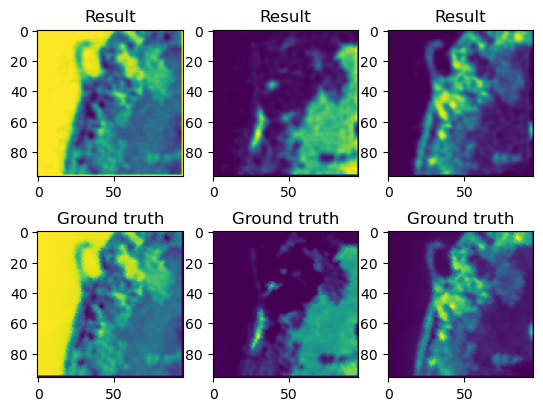

In [19]:
for i in range(3): 
    ax = plt.subplot(2, 3, i+1)
    im = A_
    im = im[0, i,:,:]
    ax.imshow(im)
    plt.title('Result')

for i in range(3): 
      ax = plt.subplot(2, 3, i+4)
      im = A_gt_tensor.view([1,3,96,96])
      im = im[0,i,:,:]
      ax.imshow(im)
      plt.title('Ground truth')

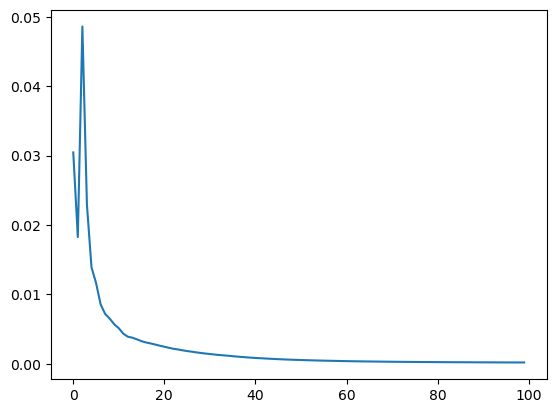

In [20]:
plt.plot(losses)

### Ecart avec groud truth

In [21]:
nn.L1Loss()(outputs[-1], A_gt_tensor.view([1,3,96,96]))

tensor(0.0264)

In [22]:
ecarts = []
for k in range(100):
  ecarts.append(nn.L1Loss()(outputs[k], A_gt_tensor.view([1,3,96,96])))


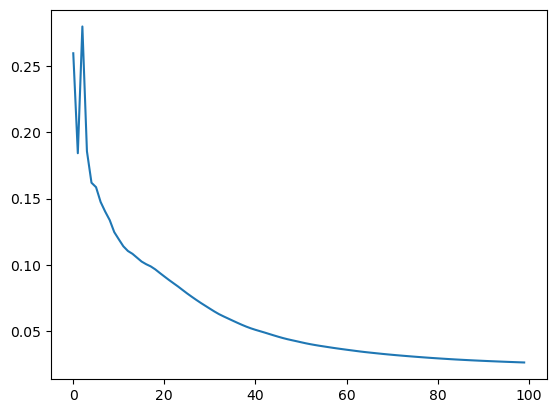

In [23]:
plt.plot(ecarts)